In [317]:
import numpy as np
import re
from forex_python.converter import CurrencyRates
import pandas as pd
from tqdm.auto import tqdm
from functools import lru_cache
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split

In [318]:
data = pd.read_csv('IMDB_Horror_Train.csv')
# print out the columns
print(data.columns)
data = data.dropna(subset=['Review Rating'])
# see what we have now
print(data.info())

Index(['Title', 'Genres', 'Release Date', 'Release Country', 'Movie Rating',
       'Movie Run Time', 'Plot', 'Cast', 'Language', 'Filming Locations',
       'Budget', 'Review Rating'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2467 non-null   object 
 1   Genres             2467 non-null   object 
 2   Release Date       2467 non-null   object 
 3   Release Country    2467 non-null   object 
 4   Movie Rating       1168 non-null   object 
 5   Movie Run Time     2166 non-null   object 
 6   Plot               2467 non-null   object 
 7   Cast               2461 non-null   object 
 8   Language           2427 non-null   object 
 9   Filming Locations  1602 non-null   object 
 10  Budget             922 non-null    object 
 11  Review Rating      2467 non-null   float64
dtypes: float64(1)

In [319]:
# We want to change the runtime and the rating into
def parse_runtime(runtime_str):
    try:
        parts = runtime_str.split()
        for part in parts:
            if part.isdigit():
                return int(part)
        return None
    except:
        return None

def parse_rating(rating_str):
    try:
        return float(rating_str)
    except:
        return None

data['Movie Run Time'] = data['Movie Run Time'].apply(parse_runtime)
data['Review Rating'] = data['Review Rating'].apply(parse_rating)
# see what we have now
print(data.head())

                                    Title  \
1                   Alien Domicile (2017)   
2                     The Corridor (2010)   
3  Pride and Prejudice and Zombies (2016)   
4                      The Wailing (2016)   
5                       Crawlspace (2012)   

                                       Genres Release Date Release Country  \
1                                      Horror    30-Mar-17             USA   
2             Drama| Horror| Sci-Fi| Thriller    30-Mar-12          Canada   
3                     Action| Horror| Romance     5-Feb-16             USA   
4   Drama| Fantasy| Horror| Mystery| Thriller     3-Jun-16             USA   
5           Horror| Mystery| Sci-Fi| Thriller    12-Nov-12              UK   

  Movie Rating  Movie Run Time  \
1          NaN            88.0   
2    NOT RATED            98.0   
3        PG-13           108.0   
4    NOT RATED           156.0   
5      UNRATED            86.0   

                                                Plot  \

In [320]:
# Now we want to one-hot encode the Movie Rating category
# First lets see what categories we have
print(data['Movie Rating'].value_counts())
# Now we can one-hot encode
data = pd.get_dummies(data, columns=['Movie Rating'], prefix='Rating')
# see what we have now
print(data.head())

Movie Rating
NOT RATED    568
R            336
UNRATED       84
TV-MA         83
PG-13         61
TV-14         27
PG             5
X              1
E              1
NC-17          1
TV-PG          1
Name: count, dtype: int64
                                    Title  \
1                   Alien Domicile (2017)   
2                     The Corridor (2010)   
3  Pride and Prejudice and Zombies (2016)   
4                      The Wailing (2016)   
5                       Crawlspace (2012)   

                                       Genres Release Date Release Country  \
1                                      Horror    30-Mar-17             USA   
2             Drama| Horror| Sci-Fi| Thriller    30-Mar-12          Canada   
3                     Action| Horror| Romance     5-Feb-16             USA   
4   Drama| Fantasy| Horror| Mystery| Thriller     3-Jun-16             USA   
5           Horror| Mystery| Sci-Fi| Thriller    12-Nov-12              UK   

   Movie Run Time                 

In [321]:
symbol_to_code = {
    '$': 'USD',  # ambiguous! might also be CAD, AUD, etc.
    '£': 'GBP',
    '€': 'EUR',
    '¥': 'JPY',
    '₹': 'INR',
    '₩': 'KRW',
    '₽': 'RUB',
    '₦': 'NGN',
    '₫': 'VND',
    '₱': 'PHP',
    '₴': 'UAH',
    '₲': 'PYG',
    # Add more if needed
}

def extract_currency_info(value: str):
    """Return (currency_code, amount) from a messy string like '£8,000,000' or 'INR 15,000,000'."""
    if not isinstance(value, str):
        return None, None

    value = value.strip()

    # Try to match known 3-letter codes first
    code_match = re.match(r'^([A-Z]{3})\s*([\d,\.]+)', value)
    if code_match:
        code = code_match.group(1)
        amount_str = code_match.group(2)
    else:
        # Try to match currency symbol
        symbol_match = re.match(r'^([^\d\s]+)\s*([\d,\.]+)', value)
        if symbol_match:
            symbol = symbol_match.group(1)
            amount_str = symbol_match.group(2)
            code = symbol_to_code.get(symbol, None)
        else:
            code = None
            amount_str = re.sub(r'[^\d\.]', '', value)

    try:
        amount = float(amount_str.replace(',', ''))
    except ValueError:
        amount = None

    return code, amount

c = CurrencyRates()

@lru_cache(maxsize=None)
def rate_to_usd(code):
    rate = c.get_rate(code, 'USD')
    print(f"Fetched rate for {code} to USD: {rate}")
    return rate

def to_usd_fast(value):
    code, amount = extract_currency_info(value)
    if not amount:
        return None
    # if not code or code == 'USD':
    return amount
    # try:
    #     return amount * rate_to_usd(code)
    # except Exception:
    #     return None


# Now apply this to the Budget
data['Budget'] = data['Budget'].apply(to_usd_fast)



In [322]:
def extract_lru_cache_items(func):
    # CPython-specific: the cache dict is in the wrapper's closure and maps keys -> linked-list node [prev,next,key,result]
    try:
        cache = None
        for cell in (func.__closure__ or ()):
            val = cell.cell_contents
            if isinstance(val, dict):
                cache = val
                break
        if cache is None:
            return {}
        items = {}
        for k, node in cache.items():
            # lru_cache keys are tuples like (code,) for positional args
            code = k[0] if isinstance(k, tuple) and k else k
            # node[-1] is the cached result
            rate = node[-1]
            items[code] = rate
        return items
    except Exception:
        return {}

# 2) Snapshot current cached rates to a JSON file (run once after your long run finished).
def snapshot_rate_cache(outfile='currency_cache.json'):
    rates = {'USD': 1.0}
    cached = extract_lru_cache_items(rate_to_usd)  # uses your existing @lru_cache function
    for code, rate in cached.items():
        if isinstance(code, str) and len(code) == 3 and rate is not None:
            rates[code] = float(rate)
    tmp = Path(outfile).with_suffix('.tmp')
    with tmp.open('w', encoding='utf-8') as f:
        json.dump(rates, f, indent=2)
    os.replace(tmp, Path(outfile))
    print(f"Snapshot written to {outfile} with {len(rates)} codes.")

# Run this once in your current Jupyter session (after the long conversion populated the cache):
# snapshot_rate_cache()

# 3) Offline converter (replace your API-based converter with this after snapshot is created).
try:
    with open('currency_cache.json', 'r', encoding='utf-8') as f:
        RATES = json.load(f)
except FileNotFoundError:
    RATES = {'USD': 1.0}

def to_usd_offline(value):
    # Reuses your existing extract_currency_info(value) function
    code, amount = extract_currency_info(value)
    if amount is None:
        return None
    if code is None or code == 'USD':
        return amount
    rate = RATES.get(code)
    return amount * rate if rate is not None else None

In [323]:
# Get the snapshot of the cache
snapshot_rate_cache()

Snapshot written to currency_cache.json with 1 codes.


In [324]:
# Now we want to split the Genres by the pipe and one hot encode them
genres_dummies = data['Genres'].str.get_dummies(sep='|')
data = pd.concat([data, genres_dummies], axis=1)
# drop the original Genres column
data = data.drop(columns=['Genres'])
# see what we have now
print(data.head())

                                    Title Release Date Release Country  \
1                   Alien Domicile (2017)    30-Mar-17             USA   
2                     The Corridor (2010)    30-Mar-12          Canada   
3  Pride and Prejudice and Zombies (2016)     5-Feb-16             USA   
4                      The Wailing (2016)     3-Jun-16             USA   
5                       Crawlspace (2012)    12-Nov-12              UK   

   Movie Run Time                                               Plot  \
1            88.0  Directed by Kelly Schwarze. With Elly Brown, A...   
2            98.0  Directed by Evan Kelly. With Stephen Chambers,...   
3           108.0  Directed by Burr Steers. With Lily James, Sam ...   
4           156.0  Directed by Hong-jin Na. With Jun Kunimura, Ju...   
5            86.0  Directed by Justin Dix. With Nicholas Bell, Ng...   

                                                Cast  \
1  Elly Brown|Ashley Campbell|Sabrina Cofield|Wil...   
2  Stephen

In [325]:
# Now we want to extract the director's name from the plot summary
def extract_director(plot_summary):
    try:
        match = re.search(r'Directed by ([\w\s]+)\.', plot_summary)
        if match:
            return match.group(1).strip()
        return None
    except:
        return None
data['Director'] = data['Plot'].apply(extract_director)
print(data.head())

                                    Title Release Date Release Country  \
1                   Alien Domicile (2017)    30-Mar-17             USA   
2                     The Corridor (2010)    30-Mar-12          Canada   
3  Pride and Prejudice and Zombies (2016)     5-Feb-16             USA   
4                      The Wailing (2016)     3-Jun-16             USA   
5                       Crawlspace (2012)    12-Nov-12              UK   

   Movie Run Time                                               Plot  \
1            88.0  Directed by Kelly Schwarze. With Elly Brown, A...   
2            98.0  Directed by Evan Kelly. With Stephen Chambers,...   
3           108.0  Directed by Burr Steers. With Lily James, Sam ...   
4           156.0  Directed by Hong-jin Na. With Jun Kunimura, Ju...   
5            86.0  Directed by Justin Dix. With Nicholas Bell, Ng...   

                                                Cast  \
1  Elly Brown|Ashley Campbell|Sabrina Cofield|Wil...   
2  Stephen

In [326]:
# Extract the first three actors from the Cast column
def extract_actors(cast_str):
    try:
        actors = cast_str.split('|')
        return [actor.strip() for actor in actors[:3]]
    except:
        return [None, None, None]
data[['Actor 1', 'Actor 2', 'Actor 3']] = pd.DataFrame(data['Cast'].apply(extract_actors).tolist(), index=data.index)

In [327]:
# The cast and plot columns are no longer needed
data = data.drop(columns=['Cast', 'Plot'])
# see what we have now
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2467 non-null   object 
 1   Release Date       2467 non-null   object 
 2   Release Country    2467 non-null   object 
 3   Movie Run Time     2166 non-null   float64
 4   Language           2427 non-null   object 
 5   Filming Locations  1602 non-null   object 
 6   Budget             922 non-null    float64
 7   Review Rating      2467 non-null   float64
 8   Rating_E           2467 non-null   bool   
 9   Rating_NC-17       2467 non-null   bool   
 10  Rating_NOT RATED   2467 non-null   bool   
 11  Rating_PG          2467 non-null   bool   
 12  Rating_PG-13       2467 non-null   bool   
 13  Rating_R           2467 non-null   bool   
 14  Rating_TV-14       2467 non-null   bool   
 15  Rating_TV-MA       2467 non-null   bool   
 16  Rating_TV-PG       2467 non-n

In [328]:
# We also want to drop the film location and movie title for now
data = data.drop(columns=['Filming Locations', 'Title'])
# Find what release countries we have
print(data['Release Country'].value_counts())

Release Country
USA            1532
UK              155
Japan            82
India            72
Philippines      56
               ... 
Iceland           1
New Zealand       1
Panama            1
Kazakhstan        1
Sri Lanka         1
Name: count, Length: 68, dtype: int64


In [329]:
# Encode the Release Country with K-folding target encoding
TARGET_COL = 'Review Rating'
COUNTRY_COL = 'Release Country'
RANDOM_STATE = 42

# Normalize: take first country if multiple and map blanks/NaN to 'Unknown'
def normalize_country(s: str) -> str:
    if pd.isna(s):
        return 'Unknown'
    s = str(s).strip()
    if not s:
        return 'Unknown'
    primary = re.split(r'\s*\|\s*|\s*,\s*', s)[0].strip()
    return primary or 'Unknown'

data[COUNTRY_COL] = data[COUNTRY_COL].apply(normalize_country)

# Rare bucketing
min_count = 10  # tune if needed
counts = data[COUNTRY_COL].value_counts()
keep = counts[counts >= min_count].index
data.loc[~data[COUNTRY_COL].isin(keep), COUNTRY_COL] = 'Other'
print(f"Country cardinality after bucketing: {data[COUNTRY_COL].nunique()}")

# Leak-free K-fold target encoding
def kfold_target_encode_no_leak(df, col, target_col, n_splits=5, smoothing=10.0, random_state=42):
    df = df.copy()
    oof = pd.Series(index=df.index, dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for tr_idx, val_idx in kf.split(df):
        tr = df.iloc[tr_idx]
        val = df.iloc[val_idx]
        fold_mean = tr[target_col].mean()

        stats = tr.groupby(col)[target_col].agg(['mean', 'count'])
        smoothed = (stats['mean'] * stats['count'] + fold_mean * smoothing) / (stats['count'] + smoothing)

        oof.iloc[val_idx] = val[col].map(smoothed).fillna(fold_mean).values

    # Fit final map for inference
    global_mean = df[target_col].mean()
    full_stats = df.groupby(col)[target_col].agg(['mean', 'count'])
    full_smoothed = (full_stats['mean'] * full_stats['count'] + global_mean * smoothing) / (full_stats['count'] + smoothing)
    return oof, full_smoothed, global_mean

# Frequency feature
country_counts = data[COUNTRY_COL].value_counts()
data['Country_Freq'] = data[COUNTRY_COL].map(country_counts).astype(int)

# Target encoding (OOF)
data['Country_TE'], COUNTRY_TE_MAP, COUNTRY_TE_GLOBAL = kfold_target_encode_no_leak(
    data, COUNTRY_COL, TARGET_COL, n_splits=5, smoothing=10.0, random_state=RANDOM_STATE
)

# Helper to transform new/test data later
def transform_country_te(series: pd.Series) -> pd.Series:
    s = series.apply(normalize_country)
    s = s.where(s.isin(COUNTRY_TE_MAP.index), 'Other')
    return s.map(COUNTRY_TE_MAP).fillna(COUNTRY_TE_GLOBAL)

# See the new features
# print(data[['Country_Freq', 'Country_TE']].head())
# Drop the original Release Country column
data = data.drop(columns=[COUNTRY_COL])
# see what we have now
print(data.info())

Country cardinality after bucketing: 26
<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Release Date      2467 non-null   object 
 1   Movie Run Time    2166 non-null   float64
 2   Language          2427 non-null   object 
 3   Budget            922 non-null    float64
 4   Review Rating     2467 non-null   float64
 5   Rating_E          2467 non-null   bool   
 6   Rating_NC-17      2467 non-null   bool   
 7   Rating_NOT RATED  2467 non-null   bool   
 8   Rating_PG         2467 non-null   bool   
 9   Rating_PG-13      2467 non-null   bool   
 10  Rating_R          2467 non-null   bool   
 11  Rating_TV-14      2467 non-null   bool   
 12  Rating_TV-MA      2467 non-null   bool   
 13  Rating_TV-PG      2467 non-null   bool   
 14  Rating_UNRATED    2467 non-null   bool   
 15  Rating_X          2467 non-null   bool   
 16   Action

In [330]:
# Now lets work with the Languages column
# We will do the same as the Release Country
LANGUAGE_COL = 'Language'
data[LANGUAGE_COL] = data[LANGUAGE_COL].apply(normalize_country)
# Rare bucketing
min_count = 10  # tune if needed
counts = data[LANGUAGE_COL].value_counts()
keep = counts[counts >= min_count].index
data.loc[~data[LANGUAGE_COL].isin(keep), LANGUAGE_COL] = 'Other'
print(f"Language cardinality after bucketing: {data[LANGUAGE_COL].nunique()}")
# Target encoding (OOF)
data['Language_TE'], LANGUAGE_TE_MAP, LANGUAGE_TE_GLOBAL = kfold_target_encode_no_leak(
    data, LANGUAGE_COL, TARGET_COL, n_splits=5, smoothing=10.0, random_state=RANDOM_STATE
)
# Frequency feature
language_counts = data[LANGUAGE_COL].value_counts()
data['Language_Freq'] = data[LANGUAGE_COL].map(language_counts).astype(int)
# Drop the original Language column
data = data.drop(columns=[LANGUAGE_COL])
# see what we have now
print(data.info())

Language cardinality after bucketing: 20
<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Release Date      2467 non-null   object 
 1   Movie Run Time    2166 non-null   float64
 2   Budget            922 non-null    float64
 3   Review Rating     2467 non-null   float64
 4   Rating_E          2467 non-null   bool   
 5   Rating_NC-17      2467 non-null   bool   
 6   Rating_NOT RATED  2467 non-null   bool   
 7   Rating_PG         2467 non-null   bool   
 8   Rating_PG-13      2467 non-null   bool   
 9   Rating_R          2467 non-null   bool   
 10  Rating_TV-14      2467 non-null   bool   
 11  Rating_TV-MA      2467 non-null   bool   
 12  Rating_TV-PG      2467 non-null   bool   
 13  Rating_UNRATED    2467 non-null   bool   
 14  Rating_X          2467 non-null   bool   
 15   Action           2467 non-null   int64  
 16   Adult

In [331]:
# The Release date column is next
# Parse exact day-mon-year with 2-digit year (e.g., 7-Sep-12)
dt = pd.to_datetime(data['Release Date'], format='%d-%b-%y', errors='coerce')

# Convert to days since epoch
epoch_days = (dt - pd.Timestamp('1970-01-01')).dt.days

# Impute missing with median and store as an int feature
fill_val = int(epoch_days.dropna().median()) if epoch_days.notna().any() else 0
data['Release_EpochDays'] = epoch_days.fillna(fill_val).astype('int32')

# Optional: drop the original string column
data.drop(columns=['Release Date'], inplace=True)

print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Movie Run Time     2166 non-null   float64
 1   Budget             922 non-null    float64
 2   Review Rating      2467 non-null   float64
 3   Rating_E           2467 non-null   bool   
 4   Rating_NC-17       2467 non-null   bool   
 5   Rating_NOT RATED   2467 non-null   bool   
 6   Rating_PG          2467 non-null   bool   
 7   Rating_PG-13       2467 non-null   bool   
 8   Rating_R           2467 non-null   bool   
 9   Rating_TV-14       2467 non-null   bool   
 10  Rating_TV-MA       2467 non-null   bool   
 11  Rating_TV-PG       2467 non-null   bool   
 12  Rating_UNRATED     2467 non-null   bool   
 13  Rating_X           2467 non-null   bool   
 14   Action            2467 non-null   int64  
 15   Adult             2467 non-null   int64  
 16   Adventure         2467 non-n

In [332]:
#Lastly we want to k-fold the director and actors
PERSONS = ['Director', 'Actor 1', 'Actor 2', 'Actor 3']
for person in PERSONS:
    data[f'{person}_TE'], PERSON_TE_MAP, PERSON_TE_GLOBAL = kfold_target_encode_no_leak(
        data, person, TARGET_COL, n_splits=5, smoothing=10.0, random_state=RANDOM_STATE
    )
    data = data.drop(columns=[person])
# see what we have now
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, 1 to 2661
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Movie Run Time     2166 non-null   float64
 1   Budget             922 non-null    float64
 2   Review Rating      2467 non-null   float64
 3   Rating_E           2467 non-null   bool   
 4   Rating_NC-17       2467 non-null   bool   
 5   Rating_NOT RATED   2467 non-null   bool   
 6   Rating_PG          2467 non-null   bool   
 7   Rating_PG-13       2467 non-null   bool   
 8   Rating_R           2467 non-null   bool   
 9   Rating_TV-14       2467 non-null   bool   
 10  Rating_TV-MA       2467 non-null   bool   
 11  Rating_TV-PG       2467 non-null   bool   
 12  Rating_UNRATED     2467 non-null   bool   
 13  Rating_X           2467 non-null   bool   
 14   Action            2467 non-null   int64  
 15   Adult             2467 non-null   int64  
 16   Adventure         2467 non-n

In [333]:
# At this point we should have only numeric columns or boolean columns
# but some may have missing values, like budget and runtime
# Fill in the missing values with the median of each column
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        median = data[col].median()
        data[col] = data[col].fillna(median)
# verify no missing values remain
print(data.isnull().sum())

Movie Run Time       0
Budget               0
Review Rating        0
Rating_E             0
Rating_NC-17         0
Rating_NOT RATED     0
Rating_PG            0
Rating_PG-13         0
Rating_R             0
Rating_TV-14         0
Rating_TV-MA         0
Rating_TV-PG         0
Rating_UNRATED       0
Rating_X             0
 Action              0
 Adult               0
 Adventure           0
 Animation           0
 Biography           0
 Comedy              0
 Crime               0
 Drama               0
 Family              0
 Fantasy             0
 History             0
 Horror              0
 Music               0
 Musical             0
 Mystery             0
 Romance             0
 Sci-Fi              0
 Sport               0
 Thriller            0
 War                 0
 Western             0
Country_Freq         0
Country_TE           0
Language_TE          0
Language_Freq        0
Release_EpochDays    0
Director_TE          0
Actor 1_TE           0
Actor 2_TE           0
Actor 3_TE 

In [334]:
# Save the processed data to a new CSV
data.to_csv('IMDB_Horror_Train_Processed.csv', index=False)

In [335]:
# Modeling time
TARGET = 'Review Rating'
X = data.drop(columns=[TARGET])
y = data[TARGET]

# Identify numeric columns needing imputation
num_cols = X.columns.tolist()

# Convert bool to int for consistency
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype('int8')


In [336]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_stages = 400  # adjust for desired granularity
model = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42,
    warm_start=True,
    n_estimators=1
)


Boosting stages: 100%|██████████| 400/400 [00:08<00:00, 45.57it/s]


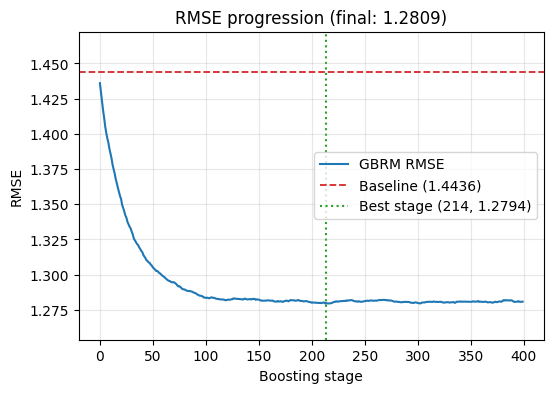

Final RMSE: 1.2809 | Best RMSE: 1.2794 at stage 214 | Baseline RMSE: 1.4436


In [337]:
# Baseline (mean predictor)
baseline_mean = y_train.mean()
baseline_pred = np.full_like(y_val, baseline_mean, dtype=float)
baseline_rmse = float(np.sqrt(mean_squared_error(y_val, baseline_pred)))
if not np.isfinite(baseline_rmse):
    raise ValueError(f'Baseline RMSE invalid: {baseline_rmse}')

rmse_history = []
best_rmse = float('inf')
best_stage = None

for stage in tqdm(range(1, max_stages + 1), desc='Boosting stages'):
    model.n_estimators = stage
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    rmse_history.append(rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_stage = stage

# Final plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(rmse_history, color='tab:blue', label='GBRM RMSE', zorder=3)

# Ensure y-range includes baseline
y_min = min(min(rmse_history), baseline_rmse)
y_max = max(max(rmse_history), baseline_rmse)
ax.set_ylim(y_min * 0.98, y_max * 1.02)

ax.axhline(baseline_rmse, color='tab:red', linestyle='--',
           linewidth=1.3, label=f'Baseline ({baseline_rmse:.4f})', zorder=2)
ax.axvline(best_stage - 1, color='tab:green', linestyle=':',
           label=f'Best stage ({best_stage}, {best_rmse:.4f})', zorder=1)

ax.set_xlabel('Boosting stage')
ax.set_ylabel('RMSE')
ax.set_title(f'RMSE progression (final: {rmse_history[-1]:.4f})')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

print(f'Final RMSE: {rmse_history[-1]:.4f} | Best RMSE: {best_rmse:.4f} at stage {best_stage} | Baseline RMSE: {baseline_rmse:.4f}')

In [338]:
pred = model.predict(X_val)

mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, pred)
r2 = r2_score(y_val, pred)

# Optional discrete accuracy (if ratings are integers, e.g., 1-10)
y_val_int = y_val.astype(int)
rounded_pred = np.rint(pred).astype(int)
accuracy = (rounded_pred == y_val_int).mean()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')
print(f'Rounded accuracy: {accuracy:.4f}')

RMSE: 1.2809
MAE: 1.0231
R^2: 0.2126
Rounded accuracy: 0.2611


Release_EpochDays    0.177515
Movie Run Time       0.148560
Director_TE          0.118350
Language_TE          0.107146
Budget               0.093060
Actor 1_TE           0.044151
Actor 3_TE           0.040693
Rating_NOT RATED     0.032058
 Drama               0.027992
Actor 2_TE           0.026544
Country_TE           0.025875
Rating_TV-MA         0.023232
 Mystery             0.020035
Country_Freq         0.015298
 Animation           0.012609
 Comedy              0.011836
Rating_TV-14         0.009933
 Sci-Fi              0.008242
 Thriller            0.007924
 Romance             0.007237
dtype: float64


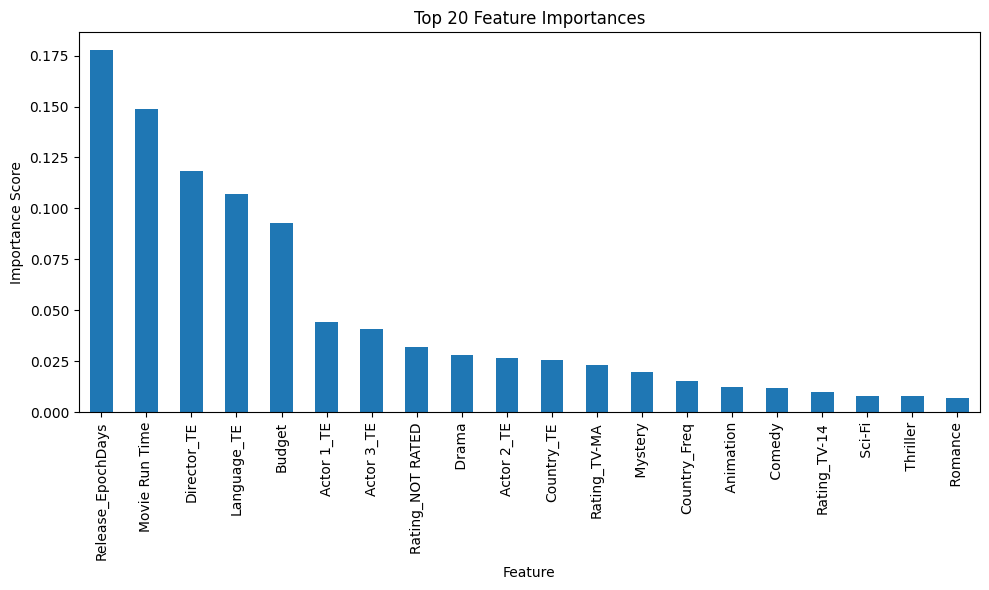

In [339]:
# display the feature importances
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(20))
# plot the feature importances
plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()